In [ ]:
import numpy as np
import cv2
import open3d as o3d
from pathlib import Path


def fov_to_focal_length(fov_degrees, image_size):
    """
    Convert field of view to focal length.

    Args:
        fov_degrees: Field of view in degrees
        image_size: Image width (for horizontal FOV) or height (for vertical FOV)

    Returns:
        Focal length in pixels
    """
    fov_radians = np.radians(fov_degrees)
    focal_length = (image_size / 2.0) / np.tan(fov_radians / 2.0)
    return focal_length


def load_depth_map(depth_path):
    """
    Load a grayscale depth map image.

    Args:
        depth_path: Path to the depth map image

    Returns:
        numpy array of the depth map
    """
    depth_img = cv2.imread(str(depth_path), cv2.IMREAD_GRAYSCALE)
    if depth_img is None:
        raise ValueError(f"Could not load depth map from {depth_path}")
    return depth_img


def depth_map_to_point_cloud(depth_map, rgb_image=None, invert_depth=True,
                             max_depth=200.0, fx=None, fy=None,
                             cx=None, cy=None, z_scale=20.0,
                             fov_horizontal=None, fov_vertical=None):
    """
    Convert a depth map to a 3D point cloud.

    Args:
        depth_map: 2D numpy array (grayscale image) where darker = closer, brighter = farther
        rgb_image: Optional RGB image for coloring the point cloud
        invert_depth: If True, invert the depth values (darker pixels = closer)
        max_depth: Maximum depth value in meters/units
        fx, fy: Focal lengths (intrinsic camera parameters). If None, will use FOV or default to 525.0
        cx, cy: Principal point (center of image). If None, uses image center
        z_scale: Additional scaling factor for Z-axis (depth) to exaggerate depth perception
        fov_horizontal: Horizontal field of view in degrees (alternative to fx)
        fov_vertical: Vertical field of view in degrees (alternative to fy)

    Returns:
        open3d.geometry.PointCloud object
    """
    height, width = depth_map.shape

    # Set principal point to image center if not provided
    if cx is None:
        cx = width / 2.0
    if cy is None:
        cy = height / 2.0

    # Calculate focal lengths from FOV if provided, otherwise use defaults
    if fov_horizontal is not None and fx is None:
        fx = fov_to_focal_length(fov_horizontal, width)
    elif fx is None:
        fx = 525.0

    if fov_vertical is not None and fy is None:
        fy = fov_to_focal_length(fov_vertical, height)
    elif fy is None:
        fy = 525.0

    # Normalize depth map to [0, 1] range
    depth_normalized = depth_map.astype(np.float32) / 255.0

    # Invert if darker means closer (which is your case)
    if invert_depth:
        depth_normalized = 1.0 - depth_normalized

    # Scale to actual depth values
    depth_values = depth_normalized * max_depth

    # Create meshgrid of pixel coordinates
    u, v = np.meshgrid(np.arange(width), np.arange(height))

    # Convert to 3D coordinates using pinhole camera model
    # X = (u - cx) * Z / fx
    # Y = (v - cy) * Z / fy
    # Z = depth
    z = depth_values
    x = (u - cx) * z / fx
    y = (v - cy) * z / fy

    # Stack coordinates and reshape to (N, 3)
    points = np.stack([x, y, z], axis=-1).reshape(-1, 3)

    # Apply additional Z-axis scaling to exaggerate depth
    points[:, 2] *= z_scale

    # Filter out points with zero or very small depth
    valid_mask = points[:, 2] > 0.01
    points = points[valid_mask]

    # Create Open3D point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    # Add colors if RGB image is provided
    if rgb_image is not None:
        if len(rgb_image.shape) == 2:
            # Convert grayscale to RGB
            rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_GRAY2RGB)
        elif rgb_image.shape[2] == 4:
            # Convert RGBA to RGB
            rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGBA2RGB)
        else:
            # Convert BGR to RGB (OpenCV loads as BGR)
            rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)

        colors = rgb_image.reshape(-1, 3)[valid_mask] / 255.0
        pcd.colors = o3d.utility.Vector3dVector(colors)
    else:
        # Use depth-based coloring (blue = close, red = far)
        colors = np.zeros((len(points), 3))
        depth_normalized_filtered = depth_normalized.flatten()[valid_mask]
        colors[:, 0] = depth_normalized_filtered  # Red channel
        colors[:, 2] = 1.0 - depth_normalized_filtered  # Blue channel
        pcd.colors = o3d.utility.Vector3dVector(colors)

    return pcd


def visualize_point_cloud(pcd, window_name="Point Cloud Viewer"):
    """
    Visualize a point cloud using Open3D.

    Args:
        pcd: open3d.geometry.PointCloud object
        window_name: Name of the visualization window
    """
    # Create a visualizer
    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name=window_name)
    vis.add_geometry(pcd)

    # Set view options
    opt = vis.get_render_option()
    opt.point_size = 2.0
    opt.background_color = np.asarray([0.1, 0.1, 0.1])

    # Run the visualizer
    vis.run()
    vis.destroy_window()


def load_and_visualize(depth_path, rgb_path=None, **kwargs):
    """
    Load a depth map (and optionally RGB image) and visualize as point cloud.

    Args:
        depth_path: Path to depth map image
        rgb_path: Optional path to RGB image
        **kwargs: Additional arguments for depth_map_to_point_cloud
    """
    # Load depth map
    depth_map = load_depth_map(depth_path)

    # Load RGB image if provided
    rgb_image = None
    if rgb_path is not None:
        rgb_image = cv2.imread(str(rgb_path))
        if rgb_image is None:
            print(f"Warning: Could not load RGB image from {rgb_path}")

    # Convert to point cloud
    pcd = depth_map_to_point_cloud(depth_map, rgb_image, **kwargs)

    # Visualize
    visualize_point_cloud(
        pcd, window_name=f"Point Cloud - {Path(depth_path).name}")

    return pcd


def batch_visualize(depth_dir, rgb_dir=None, pattern="*.png", **kwargs):
    """
    Visualize multiple depth maps from a directory.

    Args:
        depth_dir: Directory containing depth map images
        rgb_dir: Optional directory containing RGB images
        pattern: File pattern to match (default: "*.png")
        **kwargs: Additional arguments for depth_map_to_point_cloud
    """
    depth_dir = Path(depth_dir)
    depth_files = sorted(depth_dir.glob(pattern))

    if not depth_files:
        print(f"No depth maps found in {depth_dir} with pattern {pattern}")
        return

    print(f"Found {len(depth_files)} depth maps")

    for depth_path in depth_files:
        print(f"\nProcessing: {depth_path.name}")

        # Find corresponding RGB image if rgb_dir is provided
        rgb_path = None
        if rgb_dir is not None:
            rgb_path = Path(rgb_dir) / depth_path.name
            if not rgb_path.exists():
                print(f"Warning: No matching RGB image found at {rgb_path}")
                rgb_path = None

        # Load and visualize
        load_and_visualize(depth_path, rgb_path, **kwargs)


if __name__ == "__main__":
    

    # Option 2: Using FOV (uncomment to use instead)
    # batch_visualize(depth_dir, rgb_dir, max_depth=10.0,
    #                 z_scale=20.0, invert_depth=True,
    #                 fov_horizontal=60.0, fov_vertical=45.0)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
No depth maps found in data\batch01\depth with pattern *.png


In [2]:
# Example usage
import os
dataPath = "E:\\datasets\\eirt_output\\batch02"
depth_dir = os.path.join(dataPath, "depth")
rgb_dir = os.path.join(dataPath, "rgb")
mask_dir = os.path.join(dataPath, "mask_raw")

# Visualize all depth maps in the directory
# Option 1: Using focal length (current default)
batch_visualize(depth_dir, rgb_dir, max_depth=15.0,
                z_scale=20.0, invert_depth=True, fov_horizontal=39.6, fov_vertical=39.6)

Found 1 depth maps

Processing: Image0007.png


KeyboardInterrupt: 

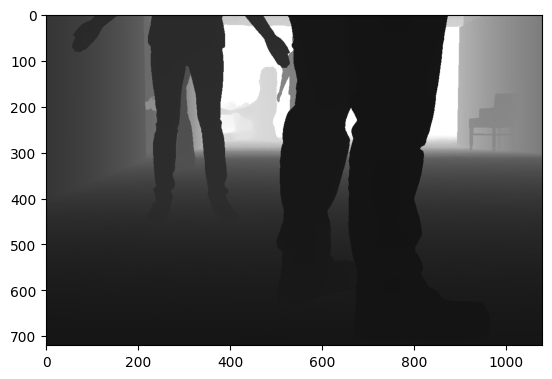

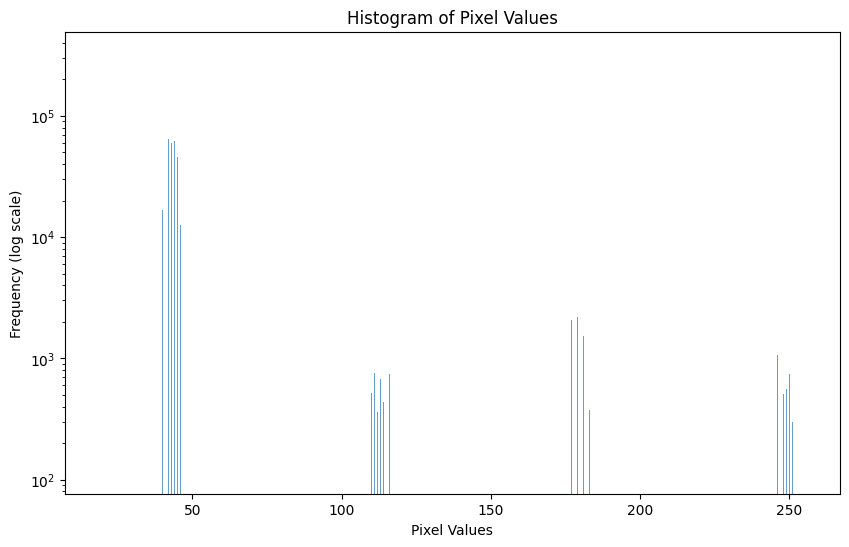

In [12]:
# Load and visualize a single depth map
from PIL import Image
# depth_map = np.array(Image.open(os.path.join(dataPath, "depth", "Image0007.png")).convert("L"))
depth_map = np.array(Image.open(os.path.join(dataPath, "depth", "Image0007.png")))

from matplotlib import pyplot as plt
plt.imshow(depth_map, cmap='gray')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(depth_map.flatten(), bins=10000, alpha=0.7)
plt.xlabel('Pixel Values')
plt.ylabel('Frequency (log scale)')
plt.title('Histogram of Pixel Values')
plt.yscale('log')
plt.show()
